# Explore here

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import *
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from pickle import dump


## Paso 1: Carga del conjunto de datos

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


## Paso 2: Construye y analiza la serie temporal

In [3]:
df.dtypes

date      object
sales    float64
dtype: object

In [4]:
df.shape

(366, 2)

In [5]:
df.isna().sum()

date     0
sales    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.nunique()

date     366
sales    366
dtype: int64

In [8]:
df_date = pd.to_datetime(df.date)
df_date = df.set_index("date")
df = df_date["sales"]
df.head()


date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

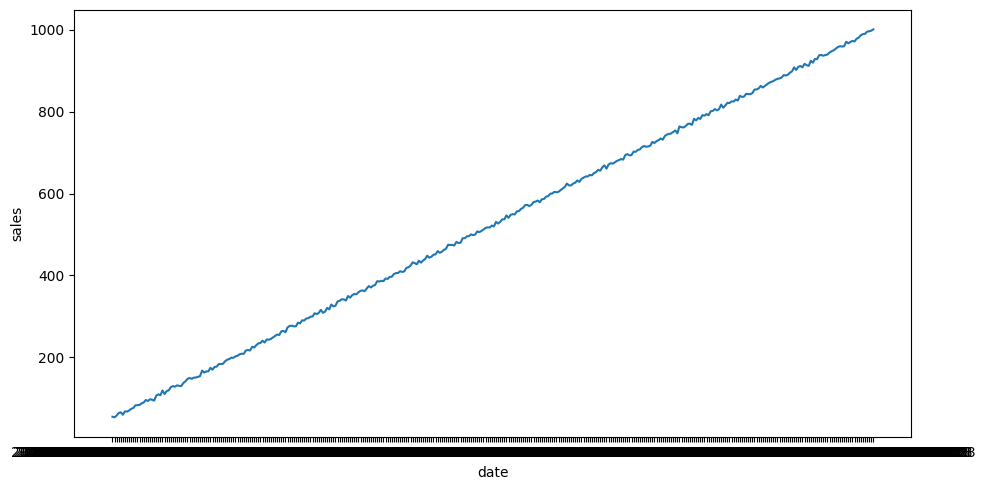

In [13]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)

plt.tight_layout()

plt.show()

In [14]:
def test_stationarity(timeseries):
    print("Resultados de la prueba Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Resultados de la prueba Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

### Descomposición de la serie

In [19]:
type(df)

pandas.core.series.Series

In [20]:
df = df.to_frame()

In [21]:
print(df.columns)

Index(['sales'], dtype='object')


In [23]:
print(df.index)

Index(['2022-09-03 17:10:08.079328', '2022-09-04 17:10:08.079328',
       '2022-09-05 17:10:08.079328', '2022-09-06 17:10:08.079328',
       '2022-09-07 17:10:08.079328', '2022-09-08 17:10:08.079328',
       '2022-09-09 17:10:08.079328', '2022-09-10 17:10:08.079328',
       '2022-09-11 17:10:08.079328', '2022-09-12 17:10:08.079328',
       ...
       '2023-08-25 17:10:08.079328', '2023-08-26 17:10:08.079328',
       '2023-08-27 17:10:08.079328', '2023-08-28 17:10:08.079328',
       '2023-08-29 17:10:08.079328', '2023-08-30 17:10:08.079328',
       '2023-08-31 17:10:08.079328', '2023-09-01 17:10:08.079328',
       '2023-09-02 17:10:08.079328', '2023-09-03 17:10:08.079328'],
      dtype='object', name='date', length=366)


In [25]:
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2022-09-03 17:10:08.079328', '2022-09-04 17:10:08.079328',
               '2022-09-05 17:10:08.079328', '2022-09-06 17:10:08.079328',
               '2022-09-07 17:10:08.079328', '2022-09-08 17:10:08.079328',
               '2022-09-09 17:10:08.079328', '2022-09-10 17:10:08.079328',
               '2022-09-11 17:10:08.079328', '2022-09-12 17:10:08.079328',
               ...
               '2023-08-25 17:10:08.079328', '2023-08-26 17:10:08.079328',
               '2023-08-27 17:10:08.079328', '2023-08-28 17:10:08.079328',
               '2023-08-29 17:10:08.079328', '2023-08-30 17:10:08.079328',
               '2023-08-31 17:10:08.079328', '2023-09-01 17:10:08.079328',
               '2023-09-02 17:10:08.079328', '2023-09-03 17:10:08.079328'],
              dtype='datetime64[ns]', name='date', length=366, freq=None)

In [27]:
decomposition = seasonal_decompose(df)
decomposition

### Análisis de tendencias

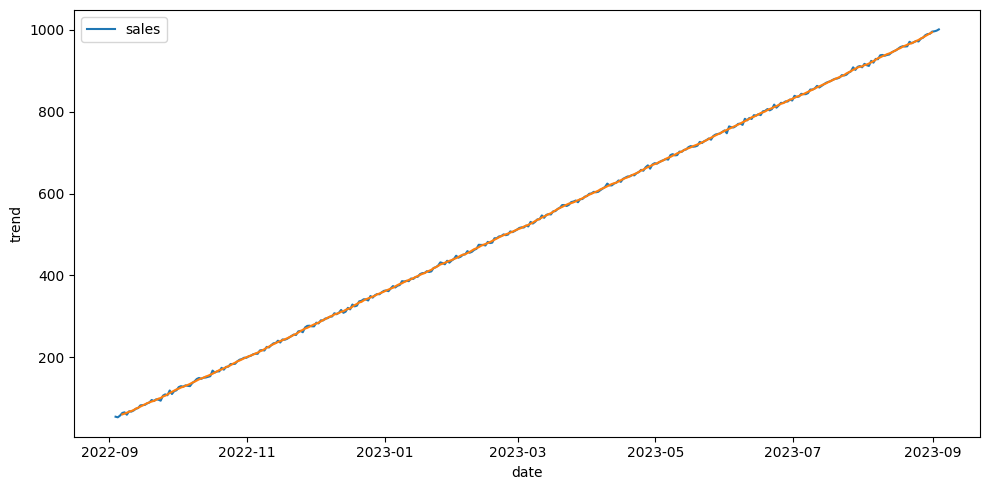

In [28]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Apreciamos una tendencia ascendente en los datos desde el inicio de la toma hasta el utimo dato

### Análisis de estacionalidad

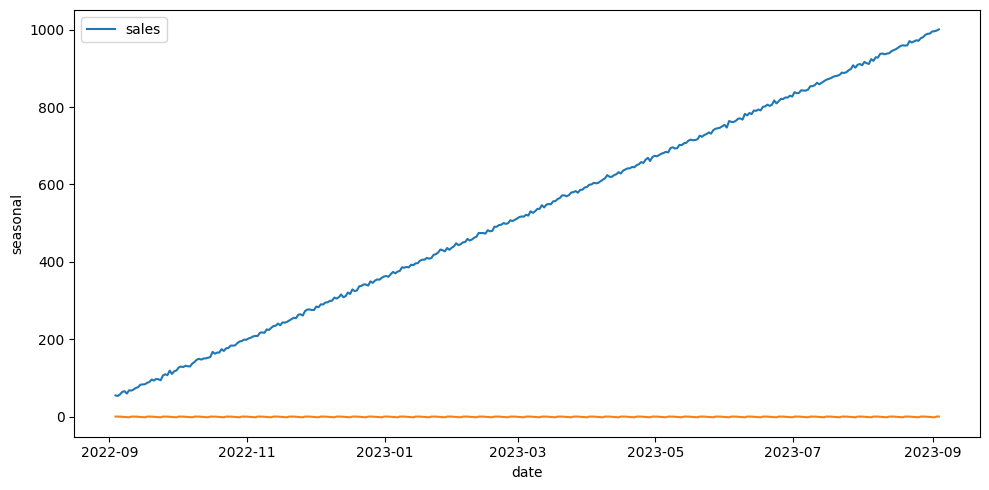

In [29]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

podemos observar que no es estacionaria 

In [30]:

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Dickey-Fuller test results:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

### Análisis de variabilidad

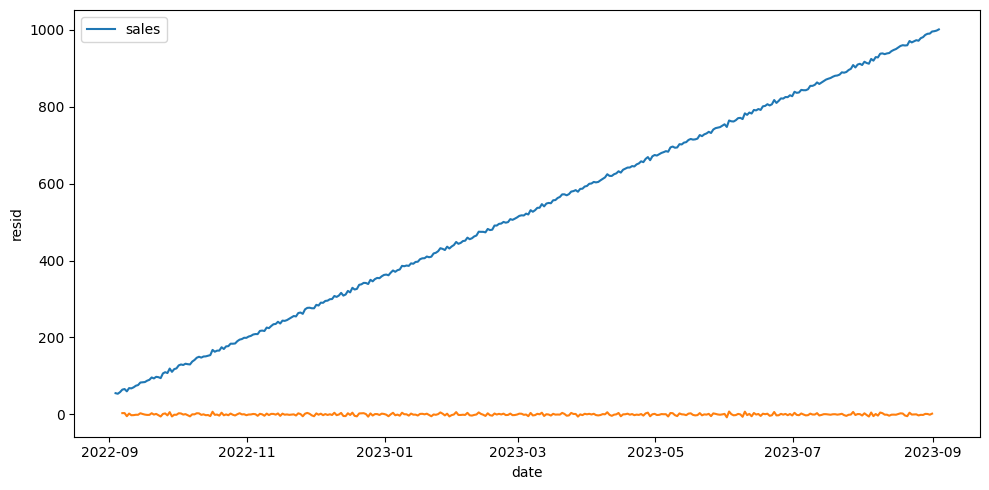

In [31]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

### Análisis de autocorrelación

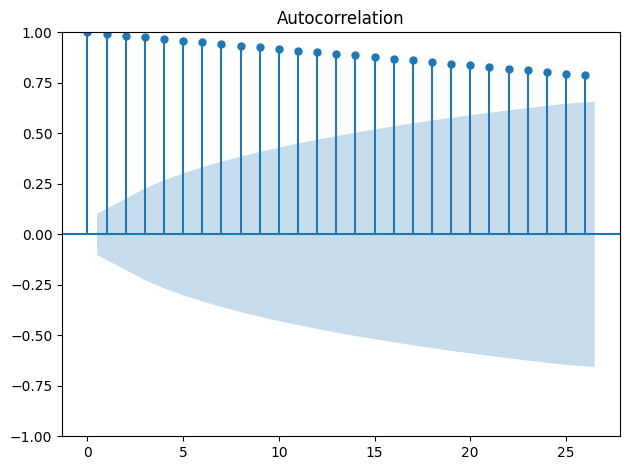

In [33]:

plot_acf(df)

plt.tight_layout()

plt.show()

## Paso 3: Entrena un ARIMA

In [37]:
model = auto_arima(df, seasonal = False, trace = True, m = 7)

/home/vscode/.local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.905 seconds


## Paso 4: Predecir con el conjunto de test

In [38]:
forecast = model.predict(60)
forecast

2023-09-04 17:10:08.079328    1002.158148
2023-09-05 17:10:08.079328    1004.831669
2023-09-06 17:10:08.079328    1007.423289
2023-09-07 17:10:08.079328    1010.021630
2023-09-08 17:10:08.079328    1012.619419
2023-09-09 17:10:08.079328    1015.217254
2023-09-10 17:10:08.079328    1017.815084
2023-09-11 17:10:08.079328    1020.412915
2023-09-12 17:10:08.079328    1023.010746
2023-09-13 17:10:08.079328    1025.608577
2023-09-14 17:10:08.079328    1028.206409
2023-09-15 17:10:08.079328    1030.804240
2023-09-16 17:10:08.079328    1033.402071
2023-09-17 17:10:08.079328    1035.999902
2023-09-18 17:10:08.079328    1038.597733
2023-09-19 17:10:08.079328    1041.195564
2023-09-20 17:10:08.079328    1043.793395
2023-09-21 17:10:08.079328    1046.391226
2023-09-22 17:10:08.079328    1048.989057
2023-09-23 17:10:08.079328    1051.586888
2023-09-24 17:10:08.079328    1054.184719
2023-09-25 17:10:08.079328    1056.782550
2023-09-26 17:10:08.079328    1059.380381
2023-09-27 17:10:08.079328    1061

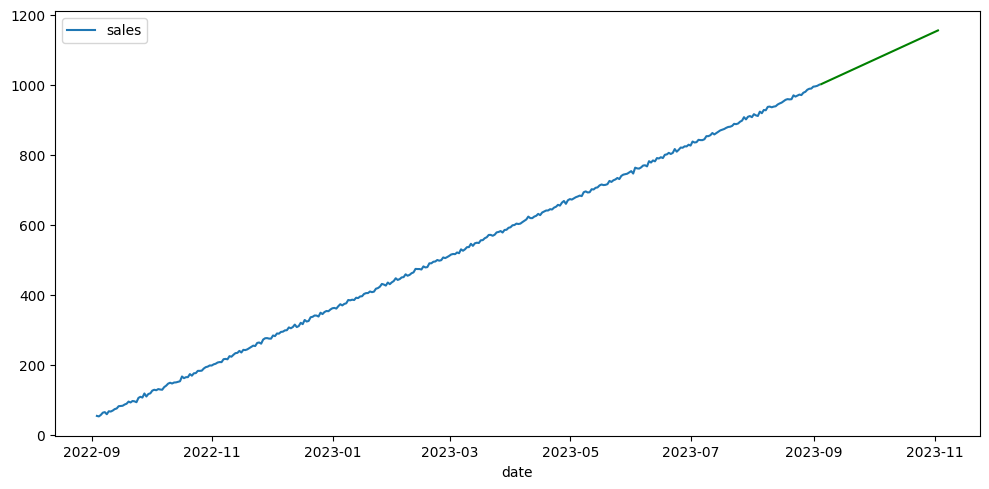

In [39]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()